In [1]:
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import TweedieRegressor
from sklearn.metrics import mean_absolute_error, mean_tweedie_deviance
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
df_freq = pq.read_table("clean_business_claims_freq.parquet").to_pandas()
df_sev = pq.read_table("clean_business_claims_sev.parquet").to_pandas()


In [3]:
df_freq.sort_values(by="solar_system", inplace=True)
df_sev.sort_values(by="solar_system", inplace=True)

In [4]:
#Grouping sev dataset based on policy id and summing claim_amount
agg_dict = {col: 'first' for col in df_sev.columns if col not in ['claim_id', 'claim_seq', 'policy_id', 'claim_amount']}
agg_dict['claim_amount'] = 'sum'

df_grouped_business_claims_sev = (
    df_sev.drop(columns=['claim_id', 'claim_seq'])
    .groupby('policy_id', as_index=False)
    .agg(agg_dict)
)

df_grouped_business_claims_sev.head(10)

,policy_id,station_id,solar_system,production_load,exposure,energy_backup_score,safety_compliance,claim_amount
0,BI-000010,G3,Zeta,0.688,0.300,4,3,4118460.0
1,BI-000015,G2,Helionis Cluster,0.414,0.570,3,5,961887.0
2,BI-000028,A9,Zeta,0.355,0.334,3,1,522526.0
3,BI-000056,B3,Epsilon,0.457,0.761,4,3,1152033.0
4,BI-000062,B2,Epsilon,0.890,0.821,4,4,2061466.0
5,BI-000072,B3,Epsilon,0.023,0.614,2,4,2860153.0
6,BI-000081,G1,Zeta,0.582,0.724,5,4,9022207.0
7,BI-000085,G3,Epsilon,0.671,0.634,1,2,3094557.0
8,BI-000092,G3,Zeta,0.821,0.713,5,3,5026302.0
9,BI-000103,G5,Zeta,0.626,0.628,4,4,2269630.0


In [5]:
#merging the two datasets on policy_id
sev_claim_amounts = df_sev.groupby('policy_id', as_index=False)['claim_amount'].sum()

df_combined = df_freq.merge(
    sev_claim_amounts, 
    on='policy_id', 
    how='left'
)

df_combined['claim_amount'] = df_combined['claim_amount'].fillna(0)

df_combined.columns

#df_combined.to_csv("bussiness_clams_model_data.csv", index=False)

Index(['policy_id', 'station_id', 'solar_system', 'production_load',
       'energy_backup_score', 'supply_chain_index', 'avg_crew_exp',
       'maintenance_freq', 'safety_compliance', 'exposure', 'claim_count',
       'claim_amount'],
      dtype='object')

── Step 1: Preparing data ──────────────────────────────────────────
  Rows after cleaning: 99,923
  Train: 79,938  |  Test: 19,985

── Step 2: Finding optimal Tweedie power ───────────────────────────
  power=1.1  mean deviance=753898.232717
  power=1.2  mean deviance=196082.211513
  power=1.3  mean deviance=52468.929318
  power=1.4  mean deviance=14500.028217
  power=1.5  mean deviance=4165.471582
  power=1.6  mean deviance=1258.458519
  power=1.7  mean deviance=409.051775
  power=1.8  mean deviance=150.736217
  power=1.9  mean deviance=74.597489

  ✓ Best power: 1.9  (deviance=74.597489)

── Step 3: Fitting sklearn Tweedie GLM ─────────────────────────────

────────────────────────────────────────
  Evaluation: Train (sklearn)
  MAE (pure premium):       2,212,576.39
  Tweedie Deviance:         74.498948
  Pearson corr (pp):        0.0560
────────────────────────────────────────

────────────────────────────────────────
  Evaluation: Test  (sklearn)
  MAE (pure premium):       2,162

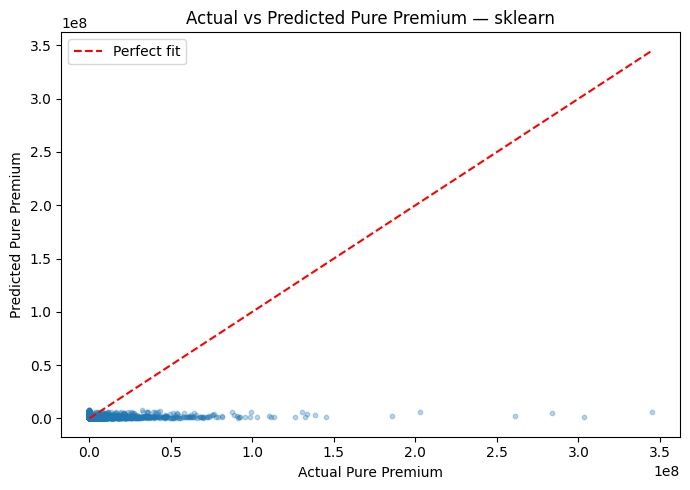


── Step 4: Fitting statsmodels GLM (with offset) ───────────────────
                 Generalized Linear Model Regression Results                  
Dep. Variable:           claim_amount   No. Observations:                79938
Model:                            GLM   Df Residuals:                    79903
Model Family:                 Tweedie   Df Model:                           34
Link Function:                    Log   Scale:                          216.13
Method:                          IRLS   Log-Likelihood:            -1.2198e+05
Date:                Mon, 23 Feb 2026   Deviance:                   5.9904e+06
Time:                        13:32:14   Pearson chi2:                 1.73e+07
No. Iterations:                    19   Pseudo R-squ. (CS):          0.0006229
Covariance Type:            nonrobust                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------

In [6]:

# ── 1. Feature Schema ─────────────────────────────────────────────────────────
NUMERIC_FEATURES = [
    "production_load",
    "energy_backup_score",
    "supply_chain_index",
    "avg_crew_exp",
    "maintenance_freq",
    "safety_compliance",
]

CATEGORICAL_FEATURES = [
    "station_id",
    "solar_system",
]

TARGET          = "claim_amount"
EXPOSURE_COL    = "exposure"


# ── 2. Data Prep ──────────────────────────────────────────────────────────────
def prepare_data(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # Safety: drop rows with non-positive exposure or negative claims
    df = df[df[EXPOSURE_COL] > 0]
    df = df[df[TARGET] >= 0]

    # Pure premium (used for evaluation, not model input)
    df["pure_premium"] = df[TARGET] / df[EXPOSURE_COL]

    # Log-offset for GLM
    df["log_exposure"] = np.log(df[EXPOSURE_COL])

    return df


# ── 3. Find Optimal Tweedie Power ─────────────────────────────────────────────
def find_optimal_power(
    X: np.ndarray,
    y: np.ndarray,
    sample_weight: np.ndarray,
    power_grid: list[float] = None,
    cv: int = 5,
) -> float:
    """
    Grid-search over Tweedie power parameter using cross-validated deviance.
    1 < p < 2 is the compound Poisson-Gamma range (correct for pure premium).
    """
    if power_grid is None:
        power_grid = np.arange(1.1, 2.0, 0.1).tolist()

    scores = {}
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)

    for p in power_grid:
        model = TweedieRegressor(power=p, alpha=0.1, link="log", max_iter=1000)
        fold_scores = []
        for train_idx, val_idx in kf.split(X):
            X_tr, X_val = X[train_idx], X[val_idx]
            y_tr, y_val = y[train_idx], y[val_idx]
            w_tr        = sample_weight[train_idx]
            model.fit(X_tr, y_tr, sample_weight=w_tr)
            preds = model.predict(X_val)
            # Tweedie deviance — lower is better
            score = mean_tweedie_deviance(y_val, preds, power=p)
            fold_scores.append(score)
        scores[p] = np.mean(fold_scores)
        print(f"  power={p:.1f}  mean deviance={scores[p]:.6f}")

    best_power = min(scores, key=scores.get)
    print(f"\n  ✓ Best power: {best_power:.1f}  (deviance={scores[best_power]:.6f})")
    return best_power


# ── 4. sklearn Pipeline ───────────────────────────────────────────────────────
def build_sklearn_pipeline(power: float) -> Pipeline:
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), NUMERIC_FEATURES),
            ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), CATEGORICAL_FEATURES),
        ]
    )
    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("glm", TweedieRegressor(power=power, alpha=0.1, link="log", max_iter=1000)),
    ])
    return pipeline


# ── 5. statsmodels GLM (with exposure offset + significance tests) ────────────
def fit_statsmodels_glm(df: pd.DataFrame, power: float):
    """
    Fits a proper actuarial Tweedie GLM with log(exposure) offset.
    statsmodels gives AIC, BIC, p-values, and confidence intervals.
    """
    # One-hot encode categoricals manually for statsmodels
    df_model = pd.get_dummies(
        df[NUMERIC_FEATURES + CATEGORICAL_FEATURES + [TARGET, "log_exposure"]],
        columns=CATEGORICAL_FEATURES,
        drop_first=True,
    )

    feature_cols = [c for c in df_model.columns if c not in [TARGET, "log_exposure"]]
    X = sm.add_constant(df_model[feature_cols].astype(float))
    y = df_model[TARGET].astype(float)
    offset = df_model["log_exposure"].astype(float)

    # Tweedie: var_power maps to sklearn power
    # p=1.5 → Tweedie, link=log
    glm = sm.GLM(
        y,
        X,
        family=sm.families.Tweedie(
            link=sm.families.links.Log(),
            var_power=power,
        ),
        offset=offset,
    )
    result = glm.fit()
    return result


# ── 6. Evaluation ─────────────────────────────────────────────────────────────
def evaluate(y_true, y_pred, exposure, power: float, label: str = ""):
    pp_true = y_true / exposure
    pp_pred = y_pred / exposure

    mae  = mean_absolute_error(pp_true, pp_pred)
    dev  = mean_tweedie_deviance(y_true, y_pred, power=power)
    # Gini-style: actual vs predicted rank correlation
    gini = np.corrcoef(pp_true, pp_pred)[0, 1]

    print(f"\n{'─'*40}")
    print(f"  Evaluation: {label}")
    print(f"  MAE (pure premium):       {mae:,.2f}")
    print(f"  Tweedie Deviance:         {dev:.6f}")
    print(f"  Pearson corr (pp):        {gini:.4f}")
    print(f"{'─'*40}")
    return {"mae": mae, "deviance": dev, "correlation": gini}


def plot_actual_vs_predicted(y_true, y_pred, exposure, label=""):
    pp_true = y_true / exposure
    pp_pred = y_pred / exposure
    plt.figure(figsize=(7, 5))
    plt.scatter(pp_true, pp_pred, alpha=0.3, s=10)
    lim = max(pp_true.max(), pp_pred.max())
    plt.plot([0, lim], [0, lim], "r--", label="Perfect fit")
    plt.xlabel("Actual Pure Premium")
    plt.ylabel("Predicted Pure Premium")
    plt.title(f"Actual vs Predicted Pure Premium — {label}")
    plt.legend()
    plt.tight_layout()
    plt.show()


# ── 7. Main ───────────────────────────────────────────────────────────────────
def run_tweedie_glm(df: pd.DataFrame):
    print("── Step 1: Preparing data ──────────────────────────────────────────")
    df = prepare_data(df)
    print(f"  Rows after cleaning: {len(df):,}")

    # Train/test split — stratify by zero vs non-zero claims
    df["_zero"] = (df[TARGET] == 0).astype(int)
    from sklearn.model_selection import train_test_split
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["_zero"])
    df.drop(columns="_zero", inplace=True)
    train_df = train_df.drop(columns="_zero")
    test_df  = test_df.drop(columns="_zero")
    print(f"  Train: {len(train_df):,}  |  Test: {len(test_df):,}")

    # Encode for sklearn
    all_features = NUMERIC_FEATURES + CATEGORICAL_FEATURES
    X_train = train_df[all_features]
    X_test  = test_df[all_features]
    y_train = train_df[TARGET].values
    y_test  = test_df[TARGET].values
    w_train = train_df[EXPOSURE_COL].values  # exposure as sample weight
    w_test  = test_df[EXPOSURE_COL].values

    print("\n── Step 2: Finding optimal Tweedie power ───────────────────────────")
    # Preprocess first for power search
    preprocessor = ColumnTransformer([
        ("num", StandardScaler(), NUMERIC_FEATURES),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), CATEGORICAL_FEATURES),
    ])
    X_train_t = preprocessor.fit_transform(X_train)
    X_test_t  = preprocessor.transform(X_test)
    best_power = find_optimal_power(X_train_t, y_train, sample_weight=w_train)

    print("\n── Step 3: Fitting sklearn Tweedie GLM ─────────────────────────────")
    pipeline = build_sklearn_pipeline(power=best_power)
    pipeline.fit(X_train, y_train, glm__sample_weight=w_train)

    train_preds = pipeline.predict(X_train)
    test_preds  = pipeline.predict(X_test)

    evaluate(y_train, train_preds, w_train, best_power, label="Train (sklearn)")
    evaluate(y_test,  test_preds,  w_test,  best_power, label="Test  (sklearn)")
    plot_actual_vs_predicted(y_test, test_preds, w_test, label="sklearn")

    print("\n── Step 4: Fitting statsmodels GLM (with offset) ───────────────────")
    sm_result = fit_statsmodels_glm(train_df, power=best_power)
    print(sm_result.summary())

    return {
        "sklearn_pipeline": pipeline,
        "statsmodels_result": sm_result,
        "best_power": best_power,
        "test_metrics": evaluate(y_test, test_preds, w_test, best_power, label="Final Test"),
    }


# ── Run ───────────────────────────────────────────────────────────────────────
results = run_tweedie_glm(df_combined)  # replace `df` with your actual DataFrame